# Лабораторна робота 2: Базові алгоритми навчання без учителя та обробка текстових даних (Scikit-learn lib)

**Виконав:** Бондар Петро


In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Завдання 1: Зниження розмірності і візуалізація даних

In [91]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns

### Вибір та завантаження датасету
Для виконання цієї лабораторної роботи було обрано датасет з лабораторної роботи 1 (оцінка рівнів ожиріння в людей з Мексико, Перу та Колумбії віком від 14 до 61).

Посилання на датасет: https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster

Виконаємо стандартну обробку датасету.

In [92]:
df_obesity = pd.read_csv('data/ObesityDataSet.csv')
df_obesity = df_obesity.rename(columns={'family_history_with_overweight': 'FAM_OVERWEIGHT', 'NObeyesdad': 'Obesity_level'})
TARGET_VAR = 'Obesity_level'
OTHER_FEATURES = df_obesity.columns.drop(['Obesity_level'])

df_obesity['MTRANS'] = df_obesity['MTRANS'].map({'Walking'               : 0.0, 
                                                 'Bike'                  : 0.15, 
                                                 'Public_Transportation' : 0.5, 
                                                 'Motorbike'             : 0.75, 
                                                 'Automobile'            : 1.0})

FREQ_CATEG_to_NUM = {'Always' : 1.0, 'Frequently' : 0.66, 'Sometimes' : 0.33, 'no' : 0.0}
BIN_CATEG_to_NUM = {'yes' : 1.0, 'no' : 0.0}

df_obesity['CAEC'] = df_obesity['CAEC'].map(FREQ_CATEG_to_NUM)
df_obesity['CALC'] = df_obesity['CALC'].map(FREQ_CATEG_to_NUM)

df_obesity['FAM_OVERWEIGHT'] = df_obesity['FAM_OVERWEIGHT'].map(BIN_CATEG_to_NUM)
df_obesity['FAVC'] = df_obesity['FAVC'].map(BIN_CATEG_to_NUM)
df_obesity['SMOKE'] = df_obesity['SMOKE'].map(BIN_CATEG_to_NUM)
df_obesity['SCC'] = df_obesity['SCC'].map(BIN_CATEG_to_NUM)
df_obesity['Gender'] = df_obesity['Gender'].map({'Male': 1.0, 'Female': 0.0})


### Відокремимо дані та мітки та перетворимо дані за допомогою StandardScaler

In [93]:
X, y = df_obesity.drop(['Obesity_level'], axis=1), df_obesity['Obesity_level']

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

### Розглянемо дисперсії по кожній змінній (Аналіз основних компонент або PCA)

In [94]:
pca = PCA()
X_pca = pca.fit_transform(X_std)

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

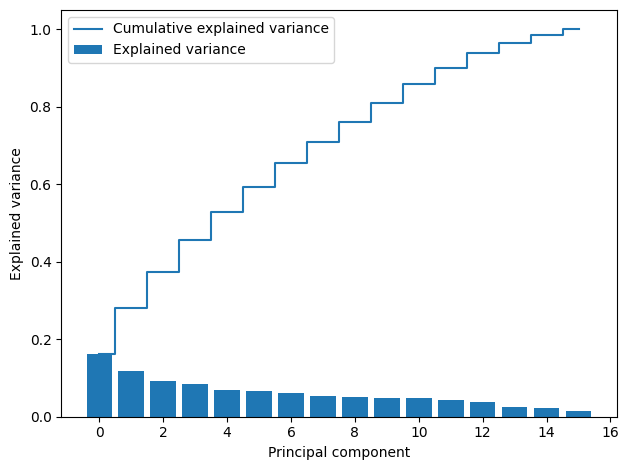

In [95]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, align='center', label='Explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance')
plt.xlabel('Principal component')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Застосуємо PCA, щоб знизити розмірність

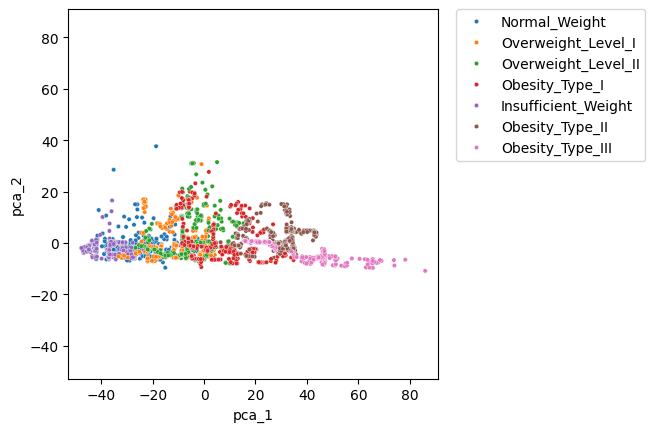

In [96]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

pca_result_df = pd.DataFrame({'pca_1': pca_result[:,0], 'pca_2': pca_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='pca_1', y='pca_2', hue='label', data=pca_result_df, ax=ax,s=10)
lim = (pca_result.min()-5, pca_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

### Для візуалізації також можемо скористатися методом tSNE

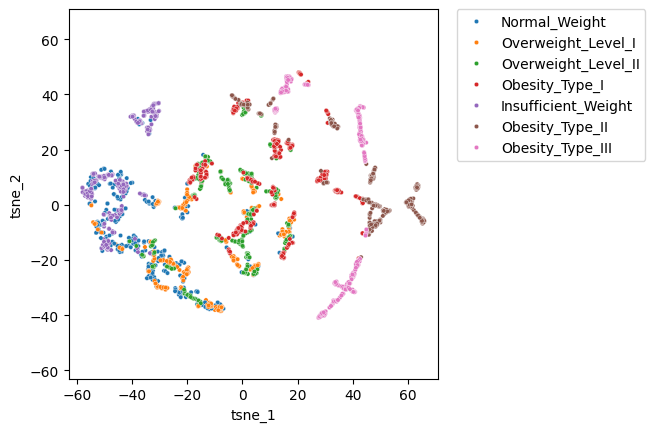

In [97]:
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(X)

tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})

fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=10)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

## Завдання 2: Кластерний аналіз

In [98]:
from PIL import Image

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)

### Завантажимо зображення та "заскейлимо RGB" значення на проміжок [0, 1]

In [99]:
image = Image.open('data/cyberpunk_city.jpg')
image_data_scaled = np.array(image, dtype=np.float64) / 255

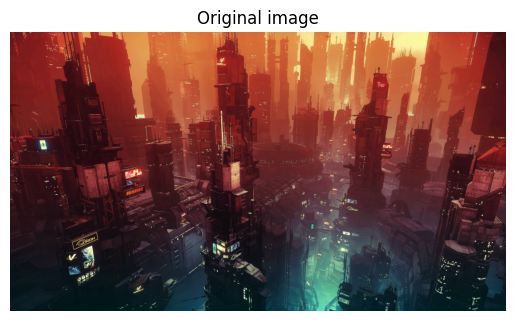

In [100]:
# Display all results, alongside original image
plt.clf()
plt.axis('off')
plt.title('Original image')
plt.imshow(image_data_scaled)

### Зведемо зобранження у двовимірний масив для застосування K-Means

In [101]:
w, h, d = original_shape = tuple(image_data_scaled.shape)
assert d == 3
image_array = np.reshape(image_data_scaled, (w * h, d))

### Стискання за допомогою K-Means до 64 кольорів

[[0.78       0.42117647 0.26784314]
 [0.30381837 0.11971104 0.14097007]
 [0.65248869 0.25158371 0.18159879]
 [0.06042781 0.13547237 0.17611408]
 [0.36078431 0.57254902 0.50098039]
 [1.         0.86666667 0.6745098 ]
 [0.51848739 0.12422969 0.11708683]
 [0.32773109 0.20672269 0.25770308]
 [0.28657617 0.29864253 0.33514329]
 [0.15106209 0.05       0.07254902]
 [0.88851541 0.57927171 0.31148459]
 [0.50239651 0.1788671  0.18409586]
 [0.39448861 0.10609433 0.11149974]
 [0.15854342 0.20028011 0.25854342]
 [0.76666667 0.63529412 0.59411765]
 [0.07377451 0.05490196 0.07720588]
 [0.65975724 0.17535014 0.13501401]
 [0.51215686 0.33098039 0.33333333]
 [0.21013072 0.18202614 0.2130719 ]
 [0.79744246 0.3887468  0.21653879]
 [0.48039216 0.4754902  0.45686275]
 [0.77183601 0.34937611 0.21069519]
 [0.91294118 0.73490196 0.44156863]
 [0.32562542 0.08830291 0.09722786]
 [0.18431373 0.43529412 0.36862745]
 [0.03452685 0.10477408 0.13043478]
 [0.27127025 0.07519182 0.09070759]
 [0.17019608 0.12862745 0.16

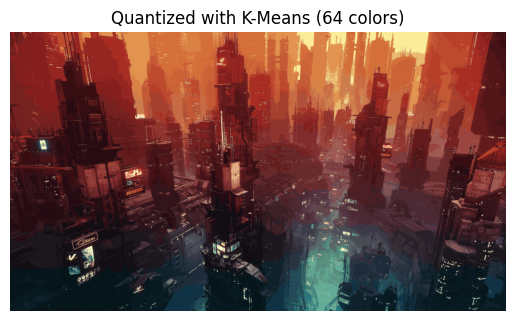

In [102]:
n_colors = 64

image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

### Стискання за допомогою K-Means до 32 кольорів

[[0.83212349 0.45874009 0.24689195]
 [0.22666667 0.12235294 0.14970588]
 [0.66741363 0.25004669 0.17684407]
 [0.0475817  0.1222658  0.15738562]
 [0.97647059 0.67843137 0.64313725]
 [0.29063181 0.41481481 0.4248366 ]
 [0.13461799 0.04962813 0.07207573]
 [0.52018454 0.1313341  0.12333718]
 [0.10010893 0.18779956 0.24793028]
 [0.31434469 0.08613691 0.09893361]
 [0.75630252 0.54005602 0.43305322]
 [0.35522876 0.53071895 0.48071895]
 [0.42491349 0.16793541 0.17093426]
 [0.29465241 0.28146168 0.32032086]
 [0.87741935 0.56318786 0.31486401]
 [0.96772247 0.9188537  0.65972851]
 [0.04184544 0.08272203 0.104406  ]
 [0.62443439 0.1670186  0.13474108]
 [0.52794118 0.38333333 0.37254902]
 [0.20836601 0.19581699 0.24418301]
 [0.40539216 0.10702614 0.10996732]
 [0.78431373 0.73803922 0.6172549 ]
 [0.13398693 0.29084967 0.34248366]
 [0.12941176 0.09685363 0.11600547]
 [0.30862745 0.16313725 0.20235294]
 [0.79103641 0.38422035 0.22203548]
 [0.52972136 0.21991744 0.21682147]
 [0.39372549 0.6745098  0.59

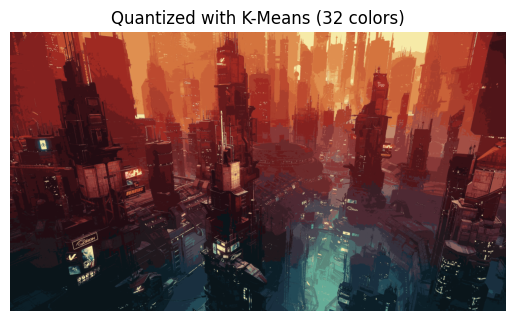

In [103]:
n_colors = 32

image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

### Стискання за допомогою K-Means до 16 кольорів

[[0.80861713 0.41073271 0.22848297]
 [0.29839216 0.11529412 0.13631373]
 [0.56880985 0.27952576 0.26994984]
 [0.03736589 0.10192379 0.12848687]
 [0.90457516 0.73986928 0.53812636]
 [0.35822021 0.52307692 0.48853695]
 [0.55803471 0.15451882 0.13856209]
 [0.25661765 0.26446078 0.30923203]
 [0.11331071 0.06749623 0.08868778]
 [0.42154754 0.13341767 0.13641155]
 [0.86623094 0.54684096 0.30466231]
 [0.70080738 0.26620531 0.18229527]
 [0.95518207 0.91428571 0.66330532]
 [0.12762923 0.18669043 0.23885918]
 [0.75860566 0.56122004 0.46884532]
 [0.21231964 0.06944136 0.09019608]]


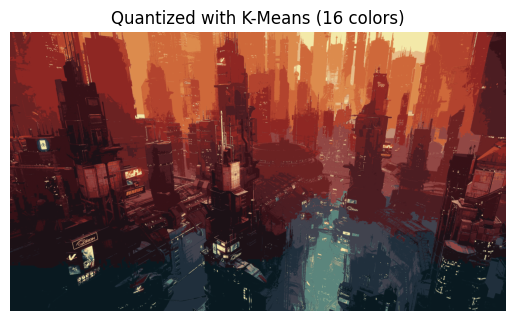

In [104]:
n_colors = 16

image_array_sample = shuffle(image_array, random_state=0, n_samples=1000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

### Стискання за допомогою K-Means до 8 кольорів

[[0.29117535 0.09990674 0.11773891]
 [0.66651866 0.26936958 0.2055291 ]
 [0.48827288 0.15076721 0.14621479]
 [0.19850737 0.22807914 0.27650398]
 [0.92709794 0.84031242 0.61309929]
 [0.09348571 0.084066   0.10892687]
 [0.8234494  0.4683727  0.27107163]
 [0.38106634 0.55908556 0.50818342]]


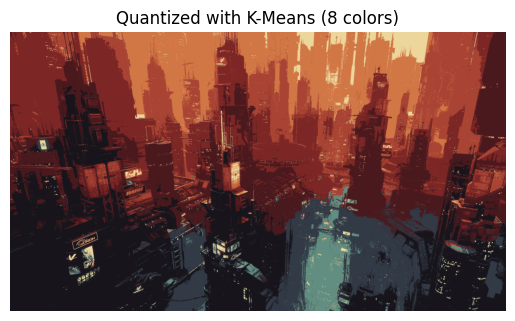

In [105]:
n_colors = 8

image_array_sample = shuffle(image_array, random_state=0)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
labels = kmeans.predict(image_array)

plt.clf()
plt.axis('off')
plt.title(f'Quantized with K-Means ({n_colors} colors)')
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

print(kmeans.cluster_centers_)

## Завдання 3: Обробка та класифікація текстових даних

In [106]:
from nltk import download
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re

download('stopwords')

def clean_line(line, stop_words):
    """Clean text from numbers, punctuation and stop words"""
    line = line.lower()
    line = re.sub(r'@\S+', ' ', line)
    line = re.sub(r'https*\S+', ' ', line)
    line = re.sub(r'#\S+', ' ', line)
    line = re.sub(r'\d', ' ', line)
    line = re.sub(r'[%s]' % re.escape(punctuation), ' ', line)
    line = re.sub(r'\n', ' ', line)
    line = re.sub(r'\s{2,}',' ', line)
    line = ' '.join([token for token in line.split(' ') if token not in stop_words])
    return line

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lollo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Вибір датасету

Для цього завдання було обрано датасет відгуків про додаток Spotify з Google Play Store за проміжок Січня-Липня 2022 року. Датасет містить текст відгуку та мітку позитивний/негативний (емоційне забарвлення).

Посилання: https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset

Проведемо загальний огляд датасету.

In [107]:
df_spotify = pd.read_csv('data/SpotifyReviews.csv')
df_spotify = df_spotify.dropna()

df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52686 entries, 0 to 52701
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  52686 non-null  object
 1   label   52686 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [108]:
df_spotify.shape

(52686, 2)

In [109]:
TEXT_COLUMN_NAME = df_spotify.columns[0]
LABEL_COLUMN_NAME = df_spotify.columns[1]

df_spotify.columns

Index(['Review', 'label'], dtype='object')

In [110]:
df_spotify.head()

,Review,label
0,"Great music service, the audio is high quality...",POSITIVE
1,Please ignore previous negative rating. This a...,POSITIVE
2,"This pop-up ""Get the best Spotify experience o...",NEGATIVE
3,Really buggy and terrible to use as of recently,NEGATIVE
4,Dear Spotify why do I get songs that I didn't ...,NEGATIVE


In [111]:
from collections import Counter
Counter(df_spotify[LABEL_COLUMN_NAME])

Counter({'NEGATIVE': 29423, 'POSITIVE': 23263})

### Очистимо тексти відгуків від пунктуації, чисел та загальних для мови неінформативних слів

In [112]:
stop_words = stopwords.words('english')
df_spotify['Review'] = df_spotify['Review'].map(lambda line: clean_line(line, stop_words))

In [113]:
df_spotify.head()

,Review,label
0,great music service audio high quality app eas...,POSITIVE
1,please ignore previous negative rating app sup...,POSITIVE
2,pop get best spotify experience android annoyi...,NEGATIVE
3,really buggy terrible use recently,NEGATIVE
4,dear spotify get songs put playlist shuffle play,NEGATIVE


### Візуалізація: зобразимо для обох класів Хмари Слів

In [114]:
from wordcloud import WordCloud

def create_wordcloud(data_frame, label):
    text = ''
    for msg in data_frame[data_frame[LABEL_COLUMN_NAME] == label][TEXT_COLUMN_NAME]:
        msg = msg.lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(f'Word cloud for \'{label}\'')
    plt.show()

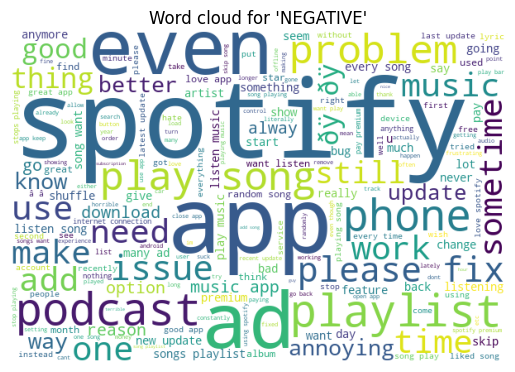

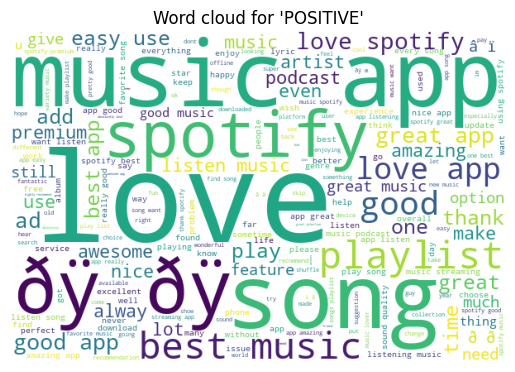

In [115]:
for label in set(df_spotify['label']):
    create_wordcloud(df_spotify, label)

### Розіб'ємо датасет на тренувальні дані та дані для перевірки

In [116]:
X_train, X_test, y_train, y_test = train_test_split(df_spotify[TEXT_COLUMN_NAME], df_spotify[LABEL_COLUMN_NAME], test_size=0.2)

len(X_train), len(y_train), len(X_test), len(y_test)

(42148, 42148, 10538, 10538)

### Векторизуємо дані за допомогою TfidfVectorizer

Таким чином перетворимо декстові дані в оцінку та підготуємо дані для тренування моделі.

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [118]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 555903 stored elements and shape (42148, 18872)>

### Модель 1: Наївний баєсів класифікатор

In [119]:
from sklearn.naive_bayes import MultinomialNB

Підберемо параметр згладжування, що дасть найменшу помилку. Це не є обов'язковим, але було цікаво подивитися :D

In [120]:
error_rate = {}

for a in [x / 10.0 for x in range(1, 20, 1)]:
    nb_trial = MultinomialNB(alpha=a)
    nb_trial.fit(X_train, y_train)
    pred_a = nb_trial.predict(X_test)
    error_rate[a] = (np.mean(pred_a != y_test))

In [121]:
alph = min(error_rate, key=error_rate.get)
alph, error_rate[alph]

(0.2, np.float64(0.13769216170051243))

Навчання та застосування моделі до тестового набору даних.

In [122]:
classifier_nb = MultinomialNB(alpha=alph)
classifier_nb.fit(X_train, y_train)

naive_bayes_predict = classifier_nb.predict(X_test)

In [123]:
print(classification_report(y_test, naive_bayes_predict))
print(confusion_matrix(y_test, naive_bayes_predict))

              precision    recall  f1-score   support

    NEGATIVE       0.86      0.90      0.88      5923
    POSITIVE       0.87      0.81      0.84      4615

    accuracy                           0.86     10538
   macro avg       0.86      0.86      0.86     10538
weighted avg       0.86      0.86      0.86     10538

[[5358  565]
 [ 886 3729]]


### Модель 2: Логістична Регресія

Ця модель застосовна, так як наші дані мають "бінарні мітки". Іншими словами, їх можна замінити на 0 і 1.

In [124]:
from sklearn.linear_model import LogisticRegression

In [125]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

lr_predict = classifier.predict(X_test)

In [126]:
print(classification_report(y_test, lr_predict))
print(confusion_matrix(y_test, lr_predict))

              precision    recall  f1-score   support

    NEGATIVE       0.88      0.91      0.90      5923
    POSITIVE       0.88      0.85      0.86      4615

    accuracy                           0.88     10538
   macro avg       0.88      0.88      0.88     10538
weighted avg       0.88      0.88      0.88     10538

[[5386  537]
 [ 702 3913]]
